# Model Comparison Notebook

This notebook reads and analyzes model evaluation results from CSV files, providing comprehensive visualizations and comparisons.

In [179]:
# =========================
# Imports and Setup
# =========================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn theme for nicer default styling
sns.set_theme(style="darkgrid", palette="deep")

# If you want nicer defaults (optional)
plt.rcParams["figure.dpi"] = 120

In [180]:
# -----------
# Load CSV
# -----------
CSV_01_PATH = "comparison_s1.csv"
df_raw_01 = pd.read_csv(CSV_01_PATH)

CSV_02_PATH = "comparison_s2.csv"
df_raw_02 = pd.read_csv(CSV_02_PATH)

df_raw = pd.concat([df_raw_01, df_raw_02], ignore_index=True)

df = df_raw.copy()

In [181]:
# -------------------------
# Cleaning / parsing helpers
# -------------------------
NA_LIKE = {"N/A", "NA", "nan", "NaN", "", None}

def parse_mean_pm(s: str):
    """
    Parse strings like "-114.86 ± 9.00" into (mean, std).
    Returns (np.nan, np.nan) if not parseable.
    """
    if pd.isna(s):
        return (np.nan, np.nan)
    s = str(s).strip()
    if s in NA_LIKE:
        return (np.nan, np.nan)
    m = re.match(r"^\s*([+-]?\d+(\.\d+)?)\s*(?:±|\+/-)\s*([+-]?\d+(\.\d+)?)\s*$", s)
    if not m:
        return (np.nan, np.nan)
    return (float(m.group(1)), float(m.group(3)))

def to_float(s):
    """Convert to float, tolerating N/A and stray whitespace."""
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if s in NA_LIKE:
        return np.nan
    try:
        return float(s)
    except ValueError:
        return np.nan

In [182]:
# Identify "mean ± std" columns by scanning for the symbol
pm_cols = [c for c in df.columns if df[c].astype(str).str.contains("±", na=False).any()]

# Parse mean±std columns into two numeric columns: <col>_mean and <col>_std
for c in pm_cols:
    means, stds = zip(*df[c].map(parse_mean_pm))
    df[c + "_mean"] = pd.to_numeric(means, errors="coerce")
    df[c + "_std"]  = pd.to_numeric(stds, errors="coerce")

# Convert obvious numeric columns (including percent columns) to floats when possible
# We'll avoid touching "Model" and other known categorical columns.
categorical_cols = {"Model", "Algorithm"}
for c in df.columns:
    if c in categorical_cols:
        continue
    # Skip the original mean±std string cols; we already parsed them
    if c in pm_cols:
        continue
    # If a column looks numeric-ish, convert
    if df[c].dtype == object:
        # try conversion; if enough values convert, keep it
        converted = df[c].map(to_float)
        # heuristic: if at least 30% parse, treat as numeric
        if converted.notna().mean() >= 0.3:
            df[c] = converted

# Make sure some key fields exist as numeric
for c in ["Style", "Deterministic", "Win Rate (%)", "Speed (eps/sec)"]:
    if c in df.columns and df[c].dtype == object:
        df[c] = df[c].map(to_float)

# Deterministic: keep as bool-ish if it is True/False strings
if "Deterministic" in df.columns:
    if df["Deterministic"].dtype == object:
        df["Deterministic"] = df["Deterministic"].astype(str).str.strip().map(
            {"True": True, "False": False, "true": True, "false": False}
        )

In [183]:
# -------------------------
# Convenience columns
# -------------------------
# A shorter label for plotting
df["ModelShort"] = df["Model"].astype(str).str.replace("_final.zip", "", regex=False)

# Reward mean/std columns (if your CSV uses "Mean Reward" with ±)
if "Mean Reward_mean" in df.columns:
    df["MeanReward"] = df["Mean Reward_mean"]
    df["StdReward"] = df["Mean Reward_std"]
elif "Mean Reward" in df.columns and pd.api.types.is_numeric_dtype(df["Mean Reward"]):
    df["MeanReward"] = df["Mean Reward"]
    df["StdReward"] = np.nan

# Episode length mean/std (if present as ±)
if "Mean Episode Length_mean" in df.columns:
    df["MeanEpLen"] = df["Mean Episode Length_mean"]
    df["StdEpLen"] = df["Mean Episode Length_std"]
elif "Mean Episode Length" in df.columns and pd.api.types.is_numeric_dtype(df["Mean Episode Length"]):
    df["MeanEpLen"] = df["Mean Episode Length"]
    df["StdEpLen"] = np.nan

In [184]:
# -------------------------
# Filtering / grouping knobs
# -------------------------
# Edit these lists to focus comparisons
FILTER_ALGORITHMS = None     # e.g. ["PPO", "PPO_LSTM"] or None for all
FILTER_STYLE      = None     # e.g. [2]
FILTER_DETERMIN   = None     # e.g. [True] or [False] or None

df_plot = df.copy()
if FILTER_ALGORITHMS is not None and "Algorithm" in df_plot.columns:
    df_plot = df_plot[df_plot["Algorithm"].isin(FILTER_ALGORITHMS)]
if FILTER_STYLE is not None and "Style" in df_plot.columns:
    df_plot = df_plot[df_plot["Style"].isin(FILTER_STYLE)]
if FILTER_DETERMIN is not None and "Deterministic" in df_plot.columns:
    df_plot = df_plot[df_plot["Deterministic"].isin(FILTER_DETERMIN)]

# Optional: choose sort key for model ordering in plots
SORT_BY = "MeanReward"  # e.g. "Win Rate (%)", "Speed (eps/sec)", "MeanReward", "MeanEpLen"
if SORT_BY in df_plot.columns:
    df_plot = df_plot.sort_values(SORT_BY, ascending=False)

In [185]:
# -------------------------
# Plot helpers (using seaborn for nicer visuals)
# -------------------------
def barh_with_optional_err(x, labels, xerr=None, title="", xlabel=""):
    plt.figure(figsize=(10, max(3, 0.35 * len(labels))))
    # seaborn barplot (horizontal) -- keep order by passing lists
    ax = sns.barplot(x=list(x), y=list(labels), orient='h', errorbar=None, hue=list(labels))
    if xerr is not None and np.isfinite(xerr).any():
        # Add errorbars manually. y positions align with bar centers (0..n-1)
        y_positions = np.arange(len(labels))
        ax.errorbar(x, y_positions, xerr=xerr, fmt='none', ecolor='black', capsize=3)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()


def safe_col(name):
    return name in df_plot.columns and pd.api.types.is_numeric_dtype(df_plot[name])

labels = df_plot["ModelShort"].tolist()

## Core Comparison Charts

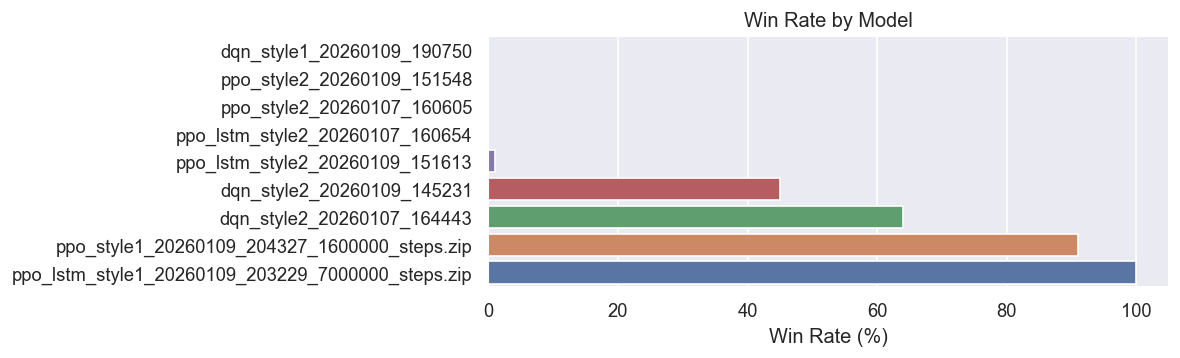

In [186]:
# Win Rate
if safe_col("Win Rate (%)"):
    barh_with_optional_err(
        df_plot["Win Rate (%)"].to_numpy(),
        labels,
        title="Win Rate by Model",
        xlabel="Win Rate (%)",
    )

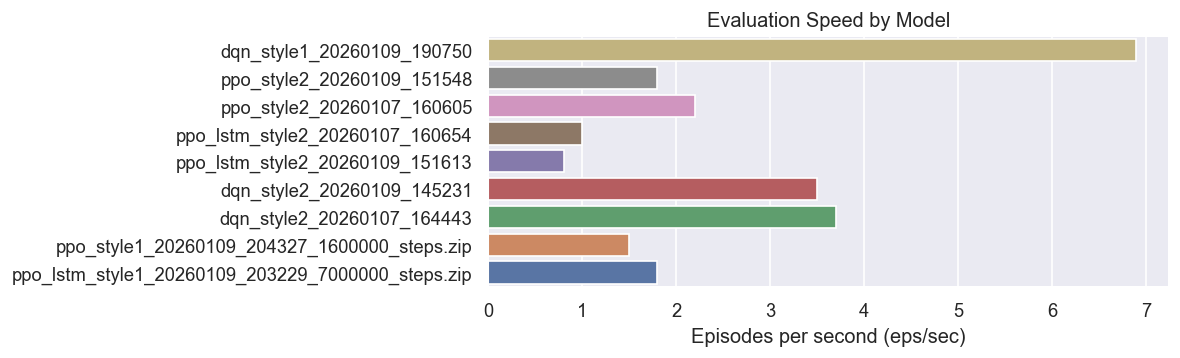

In [187]:
# Speed
if safe_col("Speed (eps/sec)"):
    barh_with_optional_err(
        df_plot["Speed (eps/sec)"].to_numpy(),
        labels,
        title="Evaluation Speed by Model",
        xlabel="Episodes per second (eps/sec)",
    )

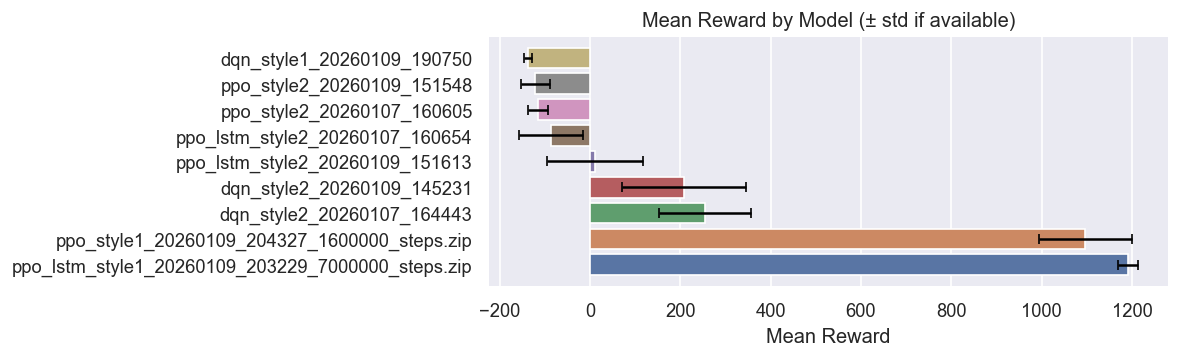

In [188]:
# Mean Reward
if safe_col("MeanReward"):
    xerr = df_plot["StdReward"].to_numpy() if safe_col("StdReward") else None
    barh_with_optional_err(
        df_plot["MeanReward"].to_numpy(),
        labels,
        xerr=xerr,
        title="Mean Reward by Model (± std if available)",
        xlabel="Mean Reward",
    )

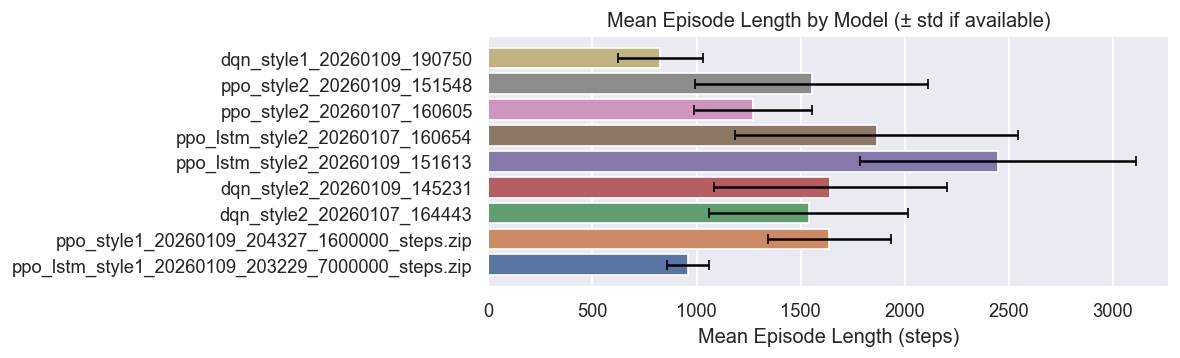

In [189]:
# Mean Episode Length
if safe_col("MeanEpLen"):
    xerr = df_plot["StdEpLen"].to_numpy() if safe_col("StdEpLen") else None
    barh_with_optional_err(
        df_plot["MeanEpLen"].to_numpy(),
        labels,
        xerr=xerr,
        title="Mean Episode Length by Model (± std if available)",
        xlabel="Mean Episode Length (steps)",
    )

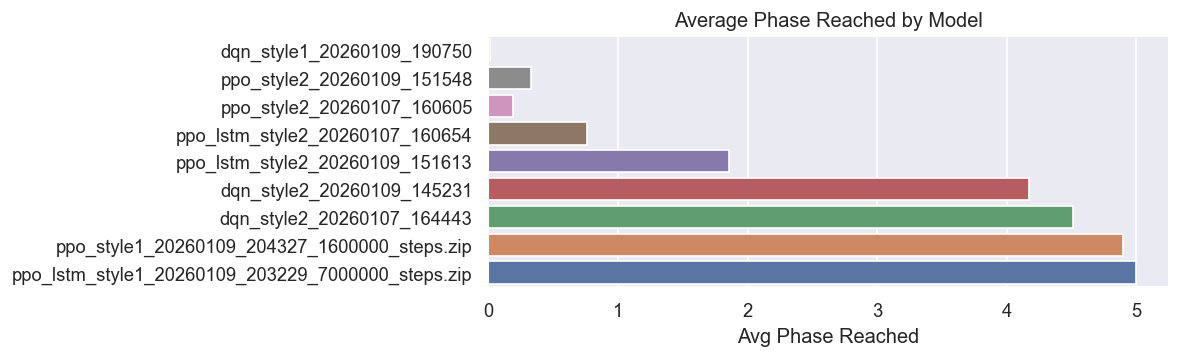

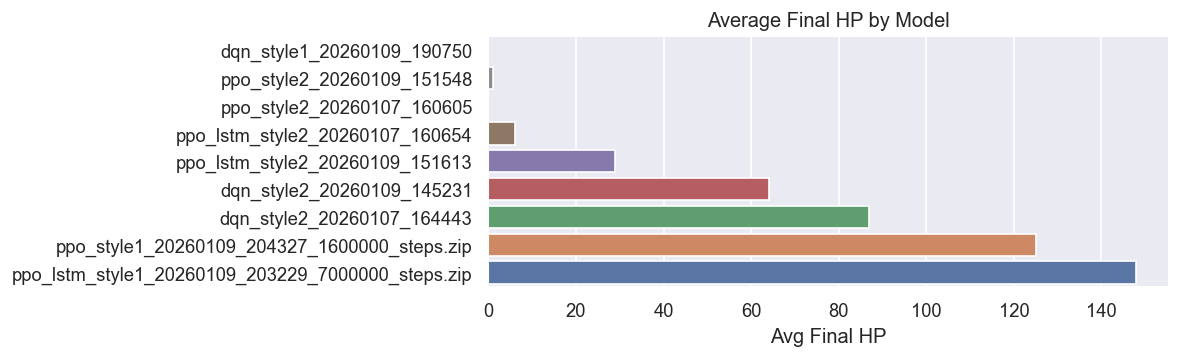

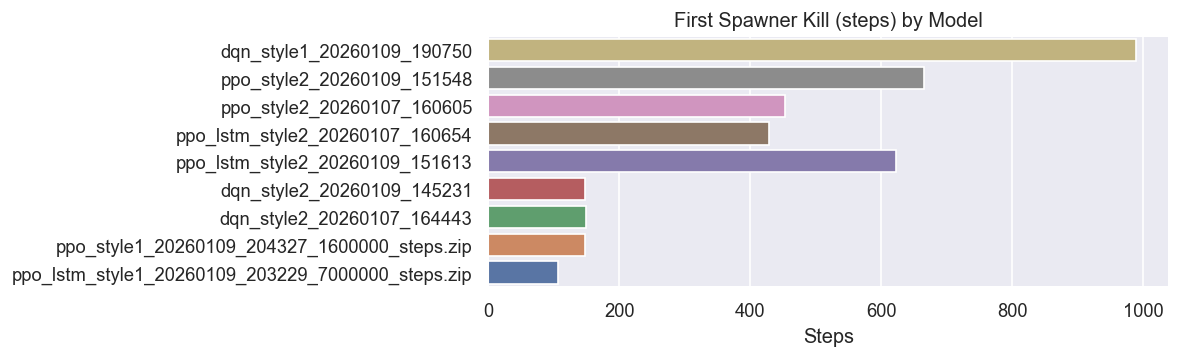

In [190]:
# Additional metrics
for extra, title, xlabel in [
    ("Avg Phase Reached", "Average Phase Reached by Model", "Avg Phase Reached"),
    ("Avg Final HP", "Average Final HP by Model", "Avg Final HP"),
    ("First Spawner Kill (steps)", "First Spawner Kill (steps) by Model", "Steps"),
]:
    if safe_col(extra):
        barh_with_optional_err(df_plot[extra].to_numpy(), labels, title=title, xlabel=xlabel)

## Distribution Heatmaps

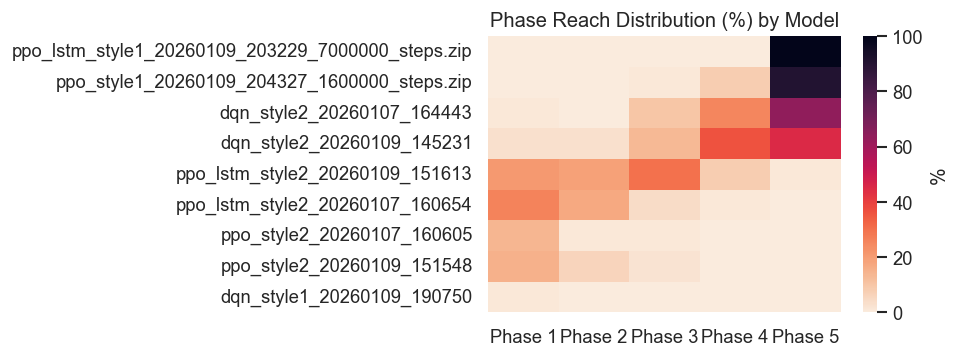

In [191]:
# -------------------------
# Phase distribution heatmap (Phase 1..5)
# -------------------------
phase_cols = [c for c in df_plot.columns if re.fullmatch(r"Phase [1-5] \(%\)", c)]
phase_cols = sorted(phase_cols, key=lambda x: int(re.findall(r"\d+", x)[0]))  # ensure order

if len(phase_cols) > 0 and all(safe_col(c) for c in phase_cols):
    phase_mat = df_plot[phase_cols].to_numpy()

    plt.figure(figsize=(8, max(3, 0.35 * len(labels))))
    sns.heatmap(phase_mat, cmap='rocket_r', yticklabels=labels, xticklabels=[c.replace(" (%)", "") for c in phase_cols], cbar_kws={'label': '%'})
    plt.title("Phase Reach Distribution (%) by Model")
    plt.tight_layout()
    plt.show()

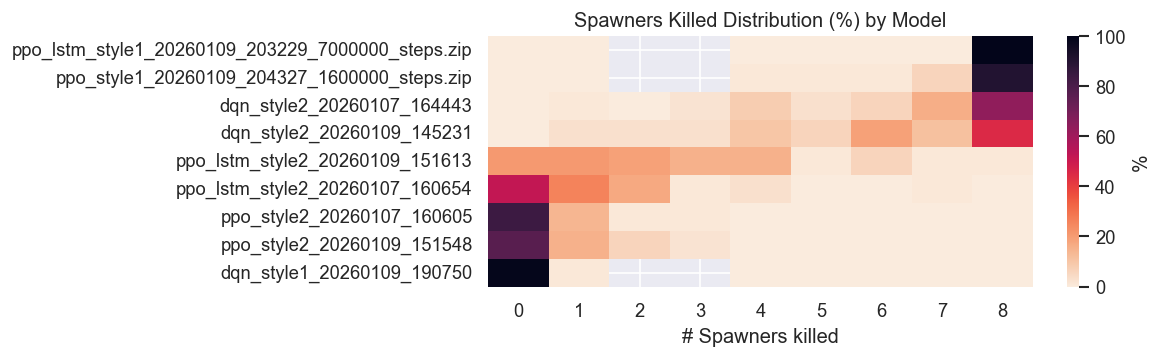

In [192]:
# -------------------------
# Spawners killed distribution heatmap (0..8)
# -------------------------
spawner_cols = [c for c in df_plot.columns if re.fullmatch(r"\d+ Spawners Killed \(%\)", c)]
# Sort numerically by leading number
spawner_cols = sorted(spawner_cols, key=lambda x: int(re.match(r"(\d+)", x).group(1))) if spawner_cols else []

if len(spawner_cols) > 0 and all(safe_col(c) for c in spawner_cols):
    sp_mat = df_plot[spawner_cols].to_numpy()

    plt.figure(figsize=(10, max(3, 0.35 * len(labels))))
    sns.heatmap(sp_mat, cmap='rocket_r', yticklabels=labels, xticklabels=[re.match(r"(\d+)", c).group(1) for c in spawner_cols], cbar_kws={'label': '%'})
    plt.title("Spawners Killed Distribution (%) by Model")
    plt.xlabel("# Spawners killed")
    plt.tight_layout()
    plt.show()

## Scatter Plots and Correlations

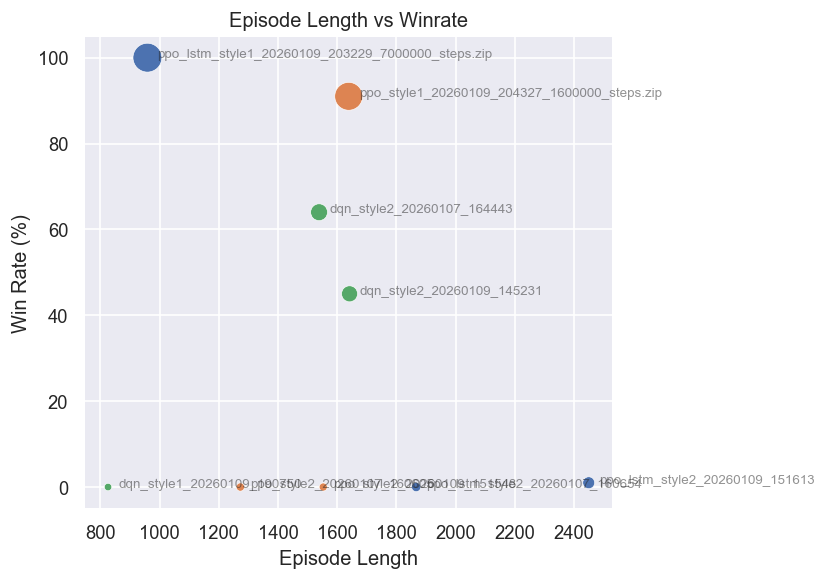

In [241]:
# -------------------------
# Scatter: Speed vs Reward (and win rate as point size if available)
# -------------------------
if safe_col("MeanEpLen") and safe_col("Speed (eps/sec)"):
    x = df_plot["MeanEpLen"].to_numpy()
    y = df_plot["Win Rate (%)"].to_numpy()

    sizes = None
    if safe_col("MeanReward"):
        wr = df_plot["MeanReward"].to_numpy()
        # scale sizes gently (avoid 0)
        sizes = 30 + 3 * np.nan_to_num(wr, nan=0.0)

    plt.figure(figsize=(7, 5))
    scatter = sns.scatterplot(x=x, y=y, size=sizes if sizes is not None else 50, sizes=(20, 300), legend=False, hue=df_plot['Algorithm'])
    for i, name in enumerate(labels):
        plt.annotate(name, (x[i], y[i]), fontsize=8, xytext=(6, 0), textcoords="offset points", alpha=0.5)
    plt.title("Episode Length vs Winrate")
    plt.xlabel("Episode Length")
    plt.ylabel("Win Rate (%)")
    plt.tight_layout()
    plt.show()

,Model,Algorithm,Style,Deterministic,Episodes,Eval Time (s),Speed (eps/sec),Win Rate (%),Avg Win Step,Mean Reward,...,Mean Reward_std,Mean Episode Length_mean,Mean Episode Length_std,Spawners / Episode_mean,Spawners / Episode_std,ModelShort,MeanReward,StdReward,MeanEpLen,StdEpLen
0,ppo_lstm_style1_20260109_203229_7000000_steps.zip,PPO_LSTM,1,False,100,54.96,1.8,100.0,959.0,1191.21 ± 21.96,...,21.96,959.0,101.0,8.00,0.00,ppo_lstm_style1_20260109_203229_7000000_steps.zip,1191.21,21.96,959.0,101.0
2,ppo_style1_20260109_204327_1600000_steps.zip,PPO,1,False,100,64.54,1.5,91.0,1651.0,1096.75 ± 103.32,...,103.32,1639.0,295.0,7.85,0.57,ppo_style1_20260109_204327_1600000_steps.zip,1096.75,103.32,1639.0,295.0
3,dqn_style2_20260107_164443_final.zip,DQN,2,False,100,27.11,3.7,64.0,1359.0,254.79 ± 102.86,...,102.86,1539.0,478.0,7.14,1.48,dqn_style2_20260107_164443,254.79,102.86,1539.0,478.0
4,dqn_style2_20260109_145231_final.zip,DQN,2,False,100,28.44,3.5,45.0,1229.0,207.99 ± 136.80,...,136.80,1642.0,560.0,6.39,1.93,dqn_style2_20260109_145231,207.99,136.80,1642.0,560.0
8,ppo_lstm_style2_20260109_151613_final.zip,PPO_LSTM,2,False,100,131.42,0.8,1.0,2832.0,10.81 ± 105.64,...,105.64,2450.0,664.0,2.20,1.85,ppo_lstm_style2_20260109_151613,10.81,105.64,2450.0,664.0
7,ppo_lstm_style2_20260107_160654_final.zip,PPO_LSTM,2,False,100,103.22,1.0,0.0,NaN,-85.70 ± 70.60,...,70.60,1867.0,680.0,0.82,1.15,ppo_lstm_style2_20260107_160654,-85.70,70.60,1867.0,680.0
5,ppo_style2_20260107_160605_final.zip,PPO,2,False,100,45.78,2.2,0.0,NaN,-115.74 ± 21.84,...,21.84,1273.0,283.0,0.19,0.48,ppo_style2_20260107_160605,-115.74,21.84,1273.0,283.0
6,ppo_style2_20260109_151548_final.zip,PPO,2,False,100,55.81,1.8,0.0,NaN,-121.11 ± 32.58,...,32.58,1553.0,560.0,0.33,0.68,ppo_style2_20260109_151548,-121.11,32.58,1553.0,560.0
1,dqn_style1_20260109_190750_final.zip,DQN,1,False,100,14.46,6.9,0.0,NaN,-137.33 ± 8.06,...,8.06,826.0,205.0,0.01,0.10,dqn_style1_20260109_190750,-137.33,8.06,826.0,205.0


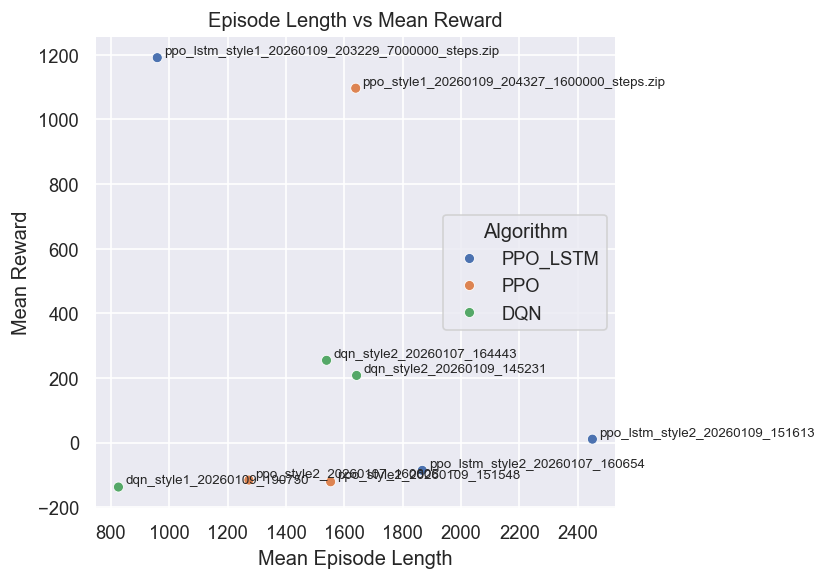

In [231]:
# -------------------------
# Scatter: Speed vs Reward (and win rate as point size if available)
# -------------------------
if safe_col("MeanEpLen") and safe_col("MeanReward"):
    x = df_plot["MeanEpLen"].to_numpy()
    y = df_plot["MeanReward"].to_numpy()

    sizes = None
    if safe_col("Win Rate (%)"):
        wr = df_plot["Win Rate (%)"].to_numpy()
        # scale sizes gently (avoid 0)
        sizes = 30 + 3 * np.nan_to_num(wr, nan=0.0)

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=x, y=y, legend=True, hue=df_plot['Algorithm'])
    for i, name in enumerate(labels):
        plt.annotate(name, (x[i], y[i]), fontsize=8, xytext=(4, 2), textcoords="offset points")
    plt.title("Episode Length vs Mean Reward")
    plt.xlabel("Mean Episode Length")
    plt.ylabel("Mean Reward")
    plt.tight_layout()
    plt.show()

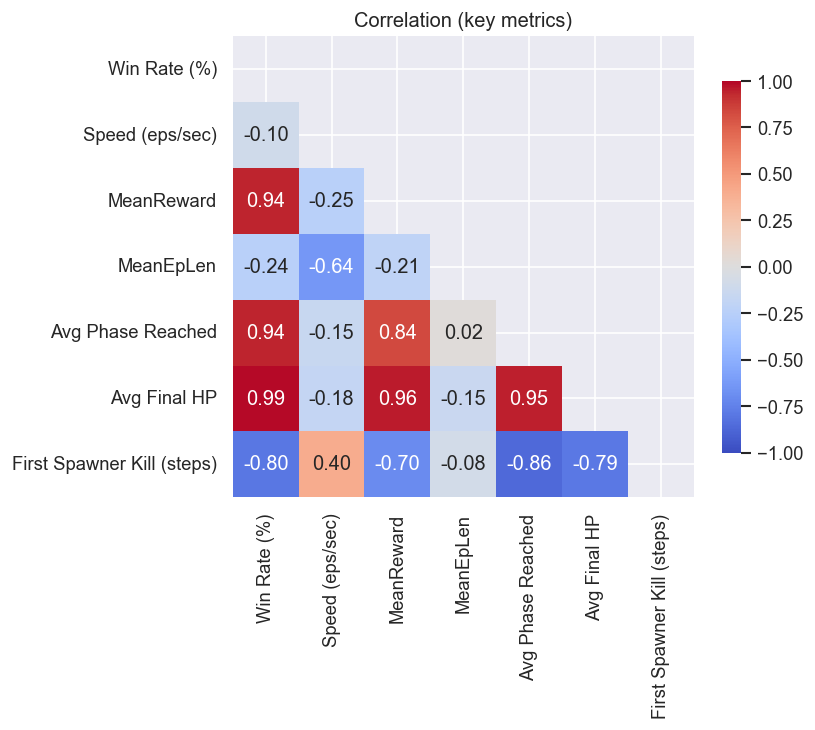

In [240]:
# -------------------------
# Correlation heatmap of key metrics
# -------------------------
key_metrics = [
    "Win Rate (%)",
    "Speed (eps/sec)",
    "MeanReward",
    "MeanEpLen",
    "Avg Phase Reached",
    "Avg Final HP",
    "First Spawner Kill (steps)",
]
# ensure we only use available numeric metrics
key_metrics = [c for c in ["Win Rate (%)", "Speed (eps/sec)", "MeanReward", "MeanEpLen", "Avg Phase Reached", "Avg Final HP", "First Spawner Kill (steps)"] if safe_col(c)]

if len(key_metrics) >= 3:
    corr_df = df_plot[key_metrics].corr(numeric_only=True)
    plt.figure(figsize=(7, 6))

    # Apply mask
    mask = np.zeros_like(corr_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.eye(mask.shape[0], dtype=bool)] = True
    
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar_kws={'shrink':0.8}, mask=mask)
    plt.title("Correlation (key metrics)")
    plt.tight_layout()
    plt.show()

## Data Table

In [197]:
# -------------------------
# Quick table to sanity check parsing
# -------------------------
display_cols = ["ModelShort", "Algorithm", "Style", "Deterministic"]
for c in ["Episodes", "Eval Time (s)", "Speed (eps/sec)", "Win Rate (%)", "MeanReward", "StdReward", "MeanEpLen", "StdEpLen"]:
    if c in df_plot.columns:
        display_cols.append(c)

print("Rows:", len(df_plot))
display(df_plot[display_cols].reset_index(drop=True))

Rows: 9


,ModelShort,Algorithm,Style,Deterministic,Episodes,Eval Time (s),Speed (eps/sec),Win Rate (%),MeanReward,StdReward,MeanEpLen,StdEpLen
0,ppo_lstm_style1_20260109_203229_7000000_steps.zip,PPO_LSTM,1,False,100,54.96,1.8,100.0,1191.21,21.96,959.0,101.0
1,ppo_style1_20260109_204327_1600000_steps.zip,PPO,1,False,100,64.54,1.5,91.0,1096.75,103.32,1639.0,295.0
2,dqn_style2_20260107_164443,DQN,2,False,100,27.11,3.7,64.0,254.79,102.86,1539.0,478.0
3,dqn_style2_20260109_145231,DQN,2,False,100,28.44,3.5,45.0,207.99,136.80,1642.0,560.0
4,ppo_lstm_style2_20260109_151613,PPO_LSTM,2,False,100,131.42,0.8,1.0,10.81,105.64,2450.0,664.0
5,ppo_lstm_style2_20260107_160654,PPO_LSTM,2,False,100,103.22,1.0,0.0,-85.70,70.60,1867.0,680.0
6,ppo_style2_20260107_160605,PPO,2,False,100,45.78,2.2,0.0,-115.74,21.84,1273.0,283.0
7,ppo_style2_20260109_151548,PPO,2,False,100,55.81,1.8,0.0,-121.11,32.58,1553.0,560.0
8,dqn_style1_20260109_190750,DQN,1,False,100,14.46,6.9,0.0,-137.33,8.06,826.0,205.0
